--------------------
# <center>--- MDI 720 - TP2 ---</center>
--------------------
*Thomas KOCH*
[LIEN A SUPPRIMER](https://github.com/MSBigData2019/Karine_Petrus/blob/master/Statistique/TP3.ipynb)




Nous travaillons sur la base de données `diabetes` de python. La base initiale comporte
$n = 442$ patients et $p = 10$ covariables. La variable $Y$ à expliquer est un score correspondant à
l’évolution de la maladie. Pour s’amuser, un robot malicieux a contaminé le jeu de données en
y ajoutant 200 variables explicatives inappropriées. Ensuite, non-content d’avoir déjà perverti
notre jeu de données, il a volontairement mélangé les variables entre elle de façon aléatoire. Bien
entendu le robot a ensuite pris soin d’effacer toute trace de son acte crapuleux si bien que nous
ne connaissons pas les variables pertinentes. La nouvelle base de données comporte $n = 442$
patients et $p = 210$ covariables, notés $X$. Saurez-vous déjouer les plans de ce robot farceur et
retrouver les variables pertinentes ?



In [49]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt  
from matplotlib import rc
from matplotlib.patches import Polygon, Circle
import matplotlib.pyplot as plt

from sklearn import linear_model, preprocessing, tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, Ridge, RidgeCV, ElasticNetCV, Lasso, lasso_path, enet_path
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV


from mpl_toolkits.mplot3d import Axes3D

from os import mkdir, path
from functools import partial  # functions that act on or return other function

from random import randint
import warnings

import scipy.stats as stat
from scipy.stats import norm
from scipy import stats

from collections import defaultdict

%matplotlib notebook

np.random.seed(seed=10)

warnings.filterwarnings('ignore')

-----------------
### Question 1 : 
>Importer la base de données data_dm3.csv disponible depuis le lien https://bitbucket.org/portierf/shared_files/downloads/data_dm3.csv. La dernière colonne est la variable à expliquer. Les autres colonnes sont les variables explicatives. Préciser le nombre de variables explicatives et le nombre d’observations.

In [2]:
# Import des données
dfDiab = pd.read_csv('data_dm3.csv',header=None)
dfDiab.head()

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,-1.298173,-0.162249,1.223379,1.355554,1.080171,0.634979,0.298741,0.548270,0.731773,1.018645,...,0.588278,0.210106,1.861458,-0.436399,0.279299,-1.416020,-2.332363,0.215096,-0.693319,151.0
1,0.166951,-0.338060,-0.618867,0.759366,1.134281,-0.536844,-0.075120,0.970251,-0.327487,0.717310,...,-0.251054,-0.825716,0.339139,1.119430,0.225958,-0.822288,0.382838,-0.718829,-0.188993,75.0
2,-0.416177,-0.205659,-1.282226,1.675500,1.523746,0.192029,-0.235840,-1.954626,-0.853309,0.892791,...,1.283837,0.372516,-0.652557,-2.579347,0.139267,-1.901196,0.048210,0.220205,0.471588,141.0
3,0.867184,-0.398667,0.093501,0.025971,1.852099,0.789774,0.801775,0.376711,0.853689,0.247953,...,0.446582,0.334733,0.399074,-0.884172,0.723819,1.316367,0.088218,0.619496,1.061662,206.0
4,1.193282,-0.936980,-0.725039,0.766078,0.223489,-1.584622,1.146866,0.086136,-0.088780,-0.945066,...,0.786157,-1.058179,-0.155788,-0.642504,2.040010,-1.703110,-1.901502,1.778811,-0.489853,135.0


In [3]:
type(dfDiab)

pandas.core.frame.DataFrame

In [4]:
dfDiab.shape

(442, 211)

In [5]:
# Observation et variable à expliquer
y_to_explain = dfDiab.iloc[:,-1]

print('Le nombre de variables explicatives est de {} .'.format(len(dfDiab.iloc[1,:])-1))
print('Le nombre d\'observations est de {} .'.format(len(y_to_explain)))

Le nombre de variables explicatives est de 210 .
Le nombre d'observations est de 442 .


-----------------
### Question 2 : 
>Les variables explicatives sont-elles centrées ? Normalisées ? Qu’en est-il de la variable à
expliquer ? Tracer un scatter plot de la base de données avec 4 covariables prises au hasard
et la variable à expliquer (un scatterplot regroupe les graphes de chacune des variables en
fonction de chacune des autres). Commenter les graphiques obtenus.

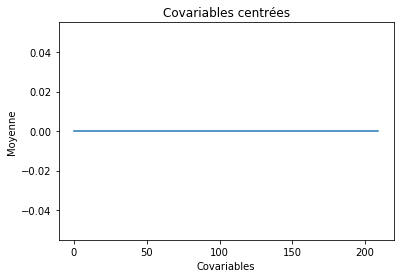

In [6]:
plt.figure()
plt.plot(round(np.mean(dfDiab.iloc[:,0:-1])))
plt.xlabel("Covariables")
plt.ylabel("Moyenne")
plt.title("Covariables centrées")
plt.show()

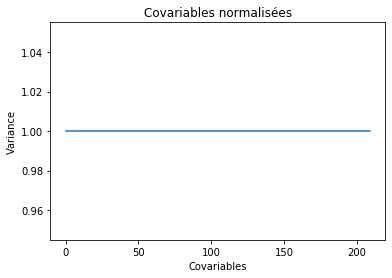

In [7]:
plt.figure()
plt.plot(round(np.var(dfDiab.iloc[:,0:-1])))
plt.xlabel("Covariables")
plt.ylabel("Variance")
plt.title("Covariables normalisées")
plt.show();

On constate donc que les covariables sont centrées et normalisées puisque leurs espérance sont égales à 0, et que leurs variances vaut 1.

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

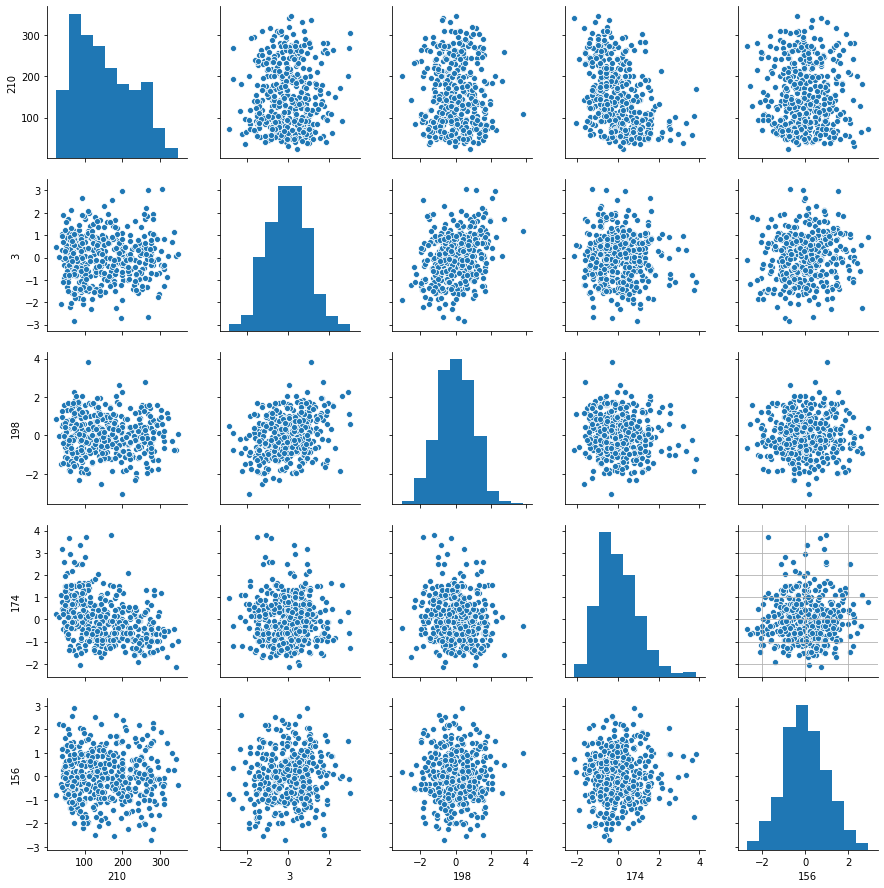

In [8]:
num_rand=[]
plt.clf()
plt.figure()

for i in range(4):
    num_rand.append(randint(0,len(dfDiab.iloc[1,:])-1))    

dfDiab1 = dfDiab.iloc[:,0:-1]
X_explanatory = dfDiab1.iloc[:,num_rand]
#pd.plotting.scatter_matrix(X_explanatory)

Y_X = pd.concat([y_to_explain,X_explanatory], axis=1)
sns.pairplot(Y_X)
plt.grid(True)
plt.show();

In [9]:
for i in range(0,4):    
    print("La covariable {} a une espérance de {:.4f} et une variance de {:.4f}".format(X_explanatory.columns[i],np.mean(X_explanatory.iloc[:,i]),np.var(X_explanatory.iloc[:,i])))

print("La variable à expliquer a pour espérance {:.2f} et pour variance {:.2f}".format(np.mean(y_to_explain),np.var(y_to_explain)))

La covariable 3 a une espérance de -0.0000 et une variance de 1.0000
La covariable 198 a une espérance de 0.0000 et une variance de 1.0000
La covariable 174 a une espérance de -0.0000 et une variance de 1.0000
La covariable 156 a une espérance de 0.0000 et une variance de 1.0000
La variable à expliquer a pour espérance 152.13 et pour variance 5929.88


On retrouve donc que les covariables sont centrées et normalisées puisque leurs espérance sont égales à 0, et que leurs variances vaut 1.

En revanche, la variable à expliquer n'est ni centrée, ni normalisée.

------------
### Question 3 :
>Echantillon d’apprentissage et de test. Créer 2 échantillons : un pour apprendre le modèle
$X_{train}$, un pour tester le modèle $X_{test}$. On mettra 20\% de la base dans l’échantillon "test". Donner les tailles de chacun des 2 échantillons. On notera que le nouvel échantillon de
covariables $X_{train}$ n’est pas normalisé. Dans la suite, on fera donc bien attention à inclure
l’intercept dans nos régression.

In [10]:
X_explanatory = dfDiab1 #on prend cette fois toutes les covariables dans X

X_train, X_test, y_train, y_test = train_test_split(X_explanatory,y_to_explain, test_size = 0.2)
print("La taille de l'échantillon d'entrainement est de {:.0f} patients.".format(len(X_train)))
print("La taille de l'échantillon de test est de {:.0f} patients.".format(len(X_test)))

La taille de l'échantillon d'entrainement est de 353 patients.
La taille de l'échantillon de test est de 89 patients.


------------
### Question 4 :

>Donner la matrice de covariance calculée sur $X_{train}$. Tracer le graphe de la décroissance des
valeurs propres de la matrice de covariance (ou de corrélation). Expliquer pourquoi il est
légitime de ne garder que les premières variables de l’ACP. On gardera 60 variables dans
la suite.

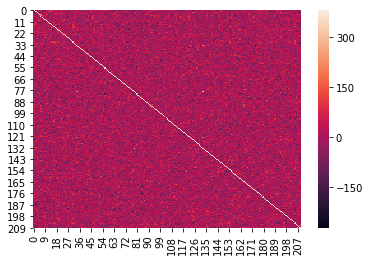

In [11]:
# Matrice de covariance

# On recentre nos données
X_train_center = X_train - np.mean(X_train)
y_train_center = y_train - np.mean(y_train)

X_test_center = X_test - np.mean(X_test)
y_test_center = y_test - np.mean(y_test)

# sns.heatmap(np.cov(X_train)) 
cov = np.dot(np.transpose(X_train_center),X_train_center)
sns.heatmap(cov)
plt.show()

In [12]:
cov.shape

(210, 210)

In [13]:
# Calcul de la matrice de corrélation
corr = X_train_center.corr()

#Calcul des valeurs propres et vecteurs propres
eigenvalues = np.linalg.eigh(corr)
eigenvectors = np.linalg.eigh(corr)[1]

<Figure size 432x288 with 0 Axes>

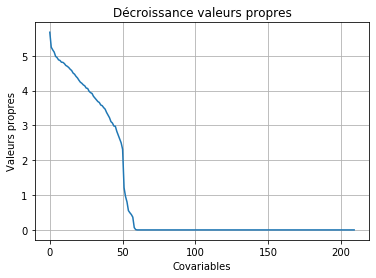

In [14]:
#Graphe de la décroissance des valeurs propres
plt.clf()
plt.figure()
plt.plot(sorted(eigenvalues[0],reverse=True))
plt.xlabel("Covariables")
plt.ylabel("Valeurs propres")
plt.title("Décroissance valeurs propres")
plt.grid(True)
plt.show()

Il est légitime de ne garder que les 60 premières variables de l'ACP car on constate avec le graphe ci-dessus que les autres variables ont des valeurs propres nulles, c'est-à-dire qu'elles sont le résultat d'une combinaison linéaire de ces 60 variables.

----------------------
### Question 5 :
>Suivant les observations de la question (Q4), appliquer la méthode de "PCA before OLS"
qui consiste à appliquer OLS avec $Y$ et $X_{train}V_{(1:60)}$, où $V_{(1:60)}$ contient les vecteurs propres (associés aux 60 plus grandes valeurs propres) de la matrice de covariance. Faire une régression linéaire (avec intercept), puis tracer les valeurs des coefficients (hors intercept).
Sur un autre graphique, faire de même avec la méthode des moindres carrés classique.

<Figure size 432x288 with 0 Axes>

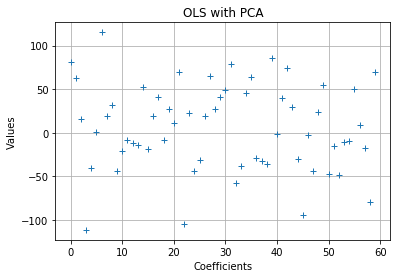

In [15]:
# PCA before OLS
# Nous n'utilisons plus les données centrées

X_pca = np.dot(X_train,np.transpose(eigenvectors[150:]))
linear_reg_pca = linear_model.LinearRegression()
linear_reg_pca.fit(X_pca , y_train)

plt.clf()
plt.figure()
plt.plot(linear_reg_pca.coef_,'+')
plt.xlabel("Coefficients")
plt.ylabel("Values")
plt.title("OLS with PCA")
plt.grid(True)
plt.show()

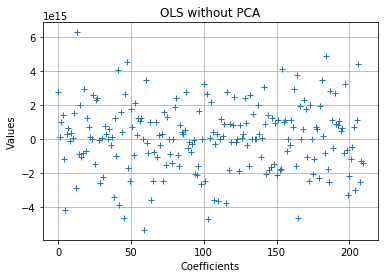

In [16]:
# OLS without PCA
X_no_pca = X_train
linear_reg_no_pca = linear_model.LinearRegression()
linear_reg_no_pca.fit(X_no_pca, y_train)

plt.figure()
plt.plot(linear_reg_no_pca.coef_,'+')
plt.xlabel("Coefficients")
plt.ylabel("Values")
plt.title("OLS without PCA")
plt.grid(True)
plt.show()

--------------
### Question 6 :

>Donner les valeurs des intercepts pour les 2 régressions précédentes. Donner la valeur
moyenne de la variable $Y$ (sur le train set). Les intercepts des 2 questions sont-ils égaux ?
Commenter. Uniquement pour cette question, centrer et réduire les variables après ACP
(de petite dimension). Faire une régression avec ces variables et vérifier que l’intercept est
bien égal à la moyenne de Y sur le train.

In [17]:
# Affichage de l'intercept pour OLS avec ACP
print("L'intercept pour l'OLS avec ACP est de {:.4f}".format(linear_reg_pca.intercept_))

# Affichage de l'intercept pour OLS sans ACP
print("L'intercept pour l'OLS sans ACP est de {:.4f}".format(linear_reg_no_pca.intercept_))

# Affichage de la moyenne de la variable y_train
print("La moyenne de la variable Y sur le dataset d'entrainement est de {:.4f}".format(y_train.mean()))

L'intercept pour l'OLS avec ACP est de 151.6108
L'intercept pour l'OLS sans ACP est de 152.4491
La moyenne de la variable Y sur le dataset d'entrainement est de 152.9178


Les données utilisées n'étant pas normalisées, il est normal que notre intercept ne soit pas exactement égal à la moyenne de la variable à expliquer.

In [18]:
# Normalisation de X_train
X_train_scaled = preprocessing.scale(X_train, with_mean='True', with_std='True')
X_pca_scaled = preprocessing.scale(X_pca, with_mean='True', with_std='True')

linear_reg1 = linear_model.LinearRegression()
linear_reg1.fit(X_train_scaled , y_train)

linear_reg2 = linear_model.LinearRegression()
linear_reg2.fit(X_pca_scaled , y_train)

# Intercept pour OLS avec ACP 
print("L'intercept pour l'OLS avec ACP et données normalisées est de {:.4f}".format(linear_reg2.intercept_))

# Moyenne de y_train
print("La moyenne de la variable y à expliquer (set d'entrainement) est de {:.4f}".format(np.mean(y_train)))

L'intercept pour l'OLS avec ACP et données normalisées est de 152.9178
La moyenne de la variable y à expliquer (set d'entrainement) est de 152.9178


-------------------------
### Question 7 :
>Pour les 2 méthodes (OLS et PCA before OLS) : 
* Tracer les résidus de la prédiction sur l’échantillon test. 
* Tracer leur densité (on pourra par exemple utiliser un histogramme).
* Calculer le coefficient de détermination sur l’échantillon test. 
* Calculer le risque de prédiction sur l’échantillon test.



-----MODELE OLS SANS ACP-----

Le risque de prédiction sur l'échantillon de test est de 4395 
Le coefficient de détermination est de R2 = 0.2969



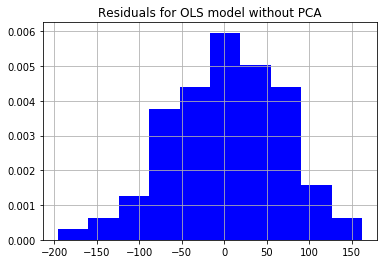

In [19]:

y_predict_no_pca = linear_reg_no_pca.predict(X_test)
residual_no_pca = y_predict_no_pca - y_test

plt.figure()
plt.hist(residual_no_pca, density=True, color="b")
plt.title("Residuals for OLS model without PCA")
plt.grid(True)

R2_no_pca = r2_score(y_test,y_predict_no_pca)

risk_score_no_pca = mean_squared_error(y_test,y_predict_no_pca)

print("\n-----MODELE OLS SANS ACP-----\n")
print("Le risque de prédiction sur l'échantillon de test est de {:.0f} ".format(risk_score_no_pca))
print("Le coefficient de détermination est de R2 = {:.4f}\n".format(R2_no_pca))


----- MODELE OLS AVEC ACP -----

Le risque de prédiction sur l'échantillon de test est de 3002 
Le coefficient de détermination est de R2 = 0.5198



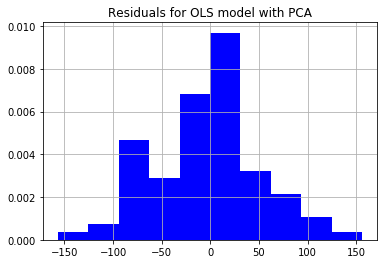

In [20]:

X_test_pca = np.dot(X_test,np.transpose(eigenvectors[150:]))
y_predict_pca = linear_reg_pca.predict(X_test_pca)
residual_pca = y_predict_pca - y_test

plt.figure()
plt.hist(residual_pca, density=True, color="b")
plt.title("Residuals for OLS model with PCA")
plt.grid(True)

risk_score_pca = mean_squared_error(y_test,y_predict_pca)
R2_pca = r2_score(y_test,y_predict_pca)

print("\n----- MODELE OLS AVEC ACP -----\n")
print("Le risque de prédiction sur l'échantillon de test est de {:.0f} ".format(risk_score_pca))
print("Le coefficient de détermination est de R2 = {:.4f}\n".format(R2_pca))

-----------------
### Question 8 :
> Coder la méthode de forward variable sélection. On pourra utiliser la statistique du test de
nullité du coefficient (comme vu en cours). Pour l’instant, on ne met pas de critère d’arret
sur la méthode. C’est à dire que l’on ajoute une variable à chaque étape jusqu’à retrouver
la totalité des variables. Afficher l’ordre de séléction des variables.

In [21]:
dfDiab1_X_aug = np.column_stack((np.ones((X_train.shape[0], 1 )), X_train)) 
n = dfDiab1_X_aug.shape[0]
p = dfDiab1_X_aug.shape[1]

test = np.zeros((p,p))
pval_mem = np.zeros(p)
pval = np.zeros((p,p))
resids = y_train

# Initialisation
var_sel = []
var_remain = list(range(p))
in_test = []

regr = linear_model.LinearRegression(fit_intercept=False)

for k in range(p): 
    resids_mem = np.zeros((p,n))
    
    for i in var_remain:
        xtmp = dfDiab1_X_aug [:,[i]]
        regr.fit(xtmp, resids)
        # Calcul de (x'x)
        xx = np.sum(dfDiab1_X_aug [:,[i]] ** 2 )   
        # print(dfDiab1_X_aug [:,[i]])
        # print(xx(1,1))
        resids_mem [i,:] = regr.predict(xtmp) - resids
        sigma2_tmp = np.sum(resids_mem [i,:] ** 2) / (xx)
        # print (k, i)
        test[k,i] = np.sqrt(n-1) * np.abs(regr.coef_) / (np.sqrt( sigma2_tmp )) 
        pval[k,i] =   2 * (1 - norm.cdf(test[k,i]))
        # print(pval)
        
    #### Séparation en deux vecteurs de la liste des variables séléctionnées et des autres
    best_var = np.argmax(test[k,:])
    var_sel.append(best_var)
    resids = resids_mem[best_var,:]
    pval_mem [k] = pval[k,best_var]
    var_remain = np.setdiff1d(var_remain, var_sel)


var_sel1 = [x-1 for x in var_sel[1:]]
df = pd.DataFrame(var_sel1)
df.columns = ['Variables sélectionnées']
print ("L'ordre de sélection des variables est le suivant : ")
print(df.to_string())

L'ordre de sélection des variables est le suivant : 
     Variables sélectionnées
0                         58
1                        123
2                        167
3                        133
4                        117
5                         47
6                         59
7                         28
8                        115
9                          1
10                       208
11                       135
12                       174
13                        87
14                        30
15                       204
16                       205
17                       209
18                       162
19                        26
20                       140
21                       145
22                        76
23                        34
24                       172
25                        53
26                       198
27                       103
28                       178
29                        93
30                       190
31                 

------------------------
### Question 9 :
>Critère d’arrêt : On décide d’arrêter lorsque la p-valeur dépasse 0.1. Illustrer la méthode
en donnant :
* ***(i)*** les 3 graphes des statistiques obtenues lors de la sélection de la 1er, 2eme
et 3eme variables (en abscisse : l’index des variables, en ordonné : la valeur des stats),
* ***(ii)*** le graphe des 50 premières p-valeurs (dont chacune est associée à la variable sélectionnée). Sur ce même graphe, on tracera la ligne horizontale d’ordonnée 0.1. 
* ***(iii)*** Enfin on donnera la liste des variables sélectionnées.

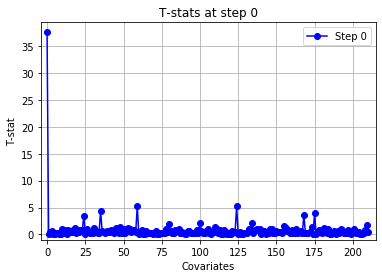

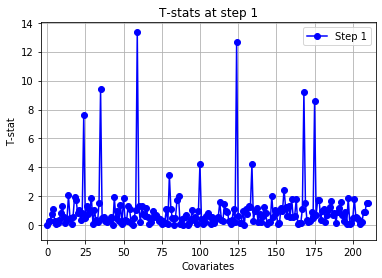

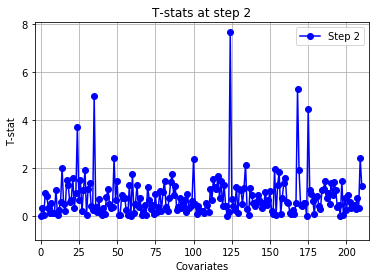

In [22]:
def step(stp):
    return "Step %s" % stp

fig = plt.figure()
for k in range(3): 
    lab_tmp = step(k)
    plt.plot(np.arange(p),test[k,:], '-o', c='blue', label = lab_tmp)
    plt.axis(xmin = -4, xmax = 215, ymin = -1)
    plt.legend()
    plt.title("T-stats at step {}".format(k))
    plt.xlabel("Covariates")
    plt.ylabel("T-stat")
    plt.grid(True)
    plt.show()

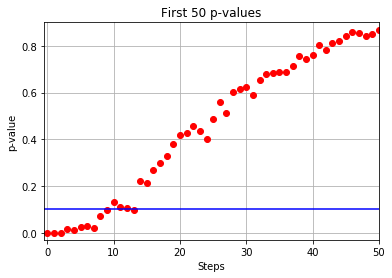

In [23]:
fig2 = plt.figure() 

plt.plot(np.arange(p), pval_mem, 'o', color = 'red')
plt.plot([-.5,50], [.1,.1], color = "blue" )
plt.axis(xmin = -.5, xmax = 50, ymin = -.03, ymax = 0.9)
plt.title("First 50 p-values")
plt.ylabel("p-value")
plt.xlabel("Steps")
plt.grid(True)
plt.show()

In [24]:
var_sel1 = np.array(var_sel)[pval_mem < 0.1]
var_sel2 = [x-1 for x in var_sel1[1:]]

print("Les variables sélectionnées (i.e. dont la p-value < 0.1) sont : \n" , var_sel2)

Les variables sélectionnées (i.e. dont la p-value < 0.1) sont : 
 [58, 123, 167, 133, 117, 47, 59, 28, 115, 174]


----------------------
### Question 10 :
>Appliquer OLS sur les variables sélectionnées. Donner le risque de prédiction obtenu avec l’échantillon test et le comparer à ceux de OLS et PCA before OLS.

In [25]:
linear_reg3 = linear_model.LinearRegression()
linear_reg3.fit(X_train.iloc[:,list(var_sel2)], y_train)

y_predict3 = linear_reg3.predict(X_test.iloc[:,list(var_sel2)])
residual3 = y_test - y_predict3

risk_score3 = mean_squared_error(y_test, y_predict3)
R2_3 = r2_score(y_test, y_predict3)

print("Le risque de prédiction est {:.0f} ".format(risk_score3))
print("Le coefficient de détermination est de R2 = {:.4f}\n".format(R2_3))

Le risque de prédiction est 3305 
Le coefficient de détermination est de R2 = 0.4714



In [26]:
print("---- risk_score comparison between each regressions ----")
print(f" |  OLS without PCA  |  OLS with PCA  | Forward model  |")
print(f" ---------------------------------------------------------")
print(f" |    {round(risk_score_no_pca,2)}        |   {round(risk_score_pca,2)}      |   {round(risk_score3,2)}      |")

 |  OLS without PCA  |  OLS with PCA  | Forward model  |
 ---------------------------------------------------------
 |    4395.24        |   3001.82      |   3304.56      |


On constate donc que le risque de prédiction avec le model forward est plus faible que celui du modèle OLS avec ACP, qui est lui-même plus faible que celui du modèle OLS sans ACP. En somme, **nous avons donc constamment diminué notre risque de prédiction**.

***Remarque*** *= Je n'ai pas sytématiquement obtenus de meilleurs résultats avec le Forward model. Il semblerait donc que* ***le modèle OLS avec ACP soit le plus fiable en terme de reproductivité***.

In [27]:
print("---- R2 comparison between each regressions ----")
print(f" |  OLS without PCA  |  OLS with PCA  | Forward model  |")
print(f" ---------------------------------------------------------")
print(f" |    {round(R2_no_pca,4)}         |   {round(R2_pca,4)}       |   {round(R2_3,4)}       |")

 |  OLS without PCA  |  OLS with PCA  | Forward model  |
 ---------------------------------------------------------
 |    0.2969         |   0.5198       |   0.4714       |


Même remarques que pour le risque de prédiction.

------------------
### Question 11 : 
>Afin de préparer la validation croisée, séparer l’échantillon train en 4 parties (appelées
"folds") de façon aléatoire. On affichera les numéros d’échantillon sélectionnés dans chaque
fold.

In [28]:
folds = KFold(4, shuffle=True)
folds.split(X_train.values)

n_splits = folds.get_n_splits(X_train)
print("Nous avons séparé l'échantillon train en {} parties.".format(n_splits))

sample_train_folds = []

for iteration, data  in enumerate(folds.split(X_train)):
    sample_train_folds.append(data[1])
    print("\n L'échantillon {} est :".format(iteration))
    print(sample_train_folds[iteration])

Nous avons séparé l'échantillon train en 4 parties.

 L'échantillon 0 est :
[  8  11  17  25  27  32  34  43  44  45  49  52  55  61  64  68  77  85
  92  93 104 113 121 134 139 140 143 150 152 155 157 167 168 171 172 173
 174 176 180 188 193 194 195 196 203 207 211 212 213 218 223 225 226 233
 234 235 237 239 247 249 251 255 263 267 270 274 277 278 285 288 289 293
 295 297 300 301 307 320 321 325 326 327 328 330 337 341 345 350 352]

 L'échantillon 1 est :
[  2  12  18  19  23  30  31  35  36  37  38  39  40  41  42  57  59  62
  63  73  74  75  78  79  80  83  84  87  89  94  99 100 101 103 106 108
 116 119 122 124 131 132 135 137 138 146 148 149 162 163 175 178 181 190
 191 192 197 204 205 206 214 217 240 242 246 248 252 256 266 269 271 272
 276 279 280 291 298 299 304 317 322 323 333 335 338 340 343 347]

 L'échantillon 2 est :
[  1   3   5   6   7   9  13  14  16  20  22  24  28  33  46  47  53  56
  60  65  66  67  71  76  90 102 112 115 120 123 126 127 142 145 153 158
 159 161 1

-------------------------
### Question 12 :
>Appliquer la méthode de la régression Ridge. Pour le choix du paramètre de régularisation,
on fera une validation croisée sur les "folds" définies lors de la question précédente. A
tour de rôle chacune des "folds" servira pour calculer le risque de prédiction alors que
les autres seront utilisées pour estimer le modèle. On moyennera ensuite les 4 risques de
prédictions. On donnera la courbe du risque de validation croisée en fonction du paramètre
de régularisation (on veillera à bien choisir l’espace de définition pour le graphe). Donner
le paramètre de régularisation optimal et la valeur du risque sur le test.

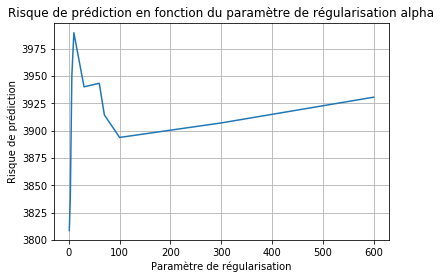

La valeur du risque minimal est 3809.0
Cette valeur est obtenue pour alpha égal à 1


In [29]:
# alpha_max = 1e3
# n_alphas = 100

alphas = [1,3,6,10,30,60,70,100,300,600]
#plt.figure()
rmse={}
rmse1=[]
rmse2=[]

for i in range(len(alphas)):
    alpha = alphas[i]
    ridge_reg = Ridge(alpha, fit_intercept=False)
    for train_idx, test_idx in folds.split(X_train):  
        #Centrage des données et entraînement du modèle
        X_train_c = X_train.iloc[train_idx] - np.mean(X_train.iloc[train_idx])
        y_train_c = y_train.iloc[train_idx] - np.mean(y_train.iloc[train_idx])
        ridge_reg.fit(X_train_c, y_train_c)
        
        X_traintest_c = X_train.iloc[test_idx] - np.mean(X_train.iloc[test_idx])
        y_traintest_c = y_train.iloc[test_idx] - np.mean(y_train.iloc[test_idx])
        y_pred = ridge_reg.predict(X_traintest_c)
        
        rmse1.append(mean_squared_error(y_pred = y_pred, y_true = y_traintest_c))
    rmsee = np.mean(rmse1)
    rmse[alpha] = rmsee
    rmse2.append(rmsee)
    
plt.figure(10)
plt.title("Risk score depending on the alpha regularization parameters")
plt.xlabel("Regularization parameters")
plt.ylabel("Risk score")
plt.plot(alphas,rmse2,'-')
plt.grid(True)
plt.show();

rmse_min = np.min(rmse2)
alpha_ridge = alphas[np.argmin(rmse2)]

print(f"La valeur du risque minimal est {round(rmse_min)}")
print(f"Cette valeur est obtenue pour alpha égal à {alpha_ridge}")

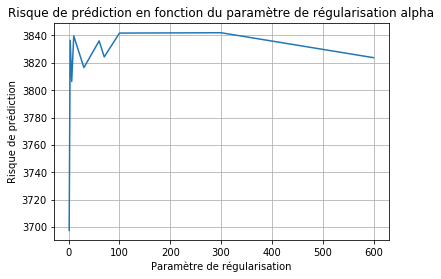

La valeur du risque minimal est 3698.0
Cette valeur est obtenue pour alpha égal à 1


In [30]:
# alpha_max = 1e3
# n_alphas = 100

alphas = [1,3,6,10,30,60,70,100,300,600]
#plt.figure()
rmse={}
rmse1=[]
rmse2=[]

ridge_reg_cv = RidgeCV(alphas, fit_intercept=False)

for i in range(len(alphas)):
    alpha = alphas[i]
    #ridge_reg = Ridge(alpha, fit_intercept=False)
    for train_idx, test_idx in folds.split(X_train):  
        #Centrage des données et entraînement du modèle
        X_train_c = X_train.iloc[train_idx] - np.mean(X_train.iloc[train_idx])
        y_train_c = y_train.iloc[train_idx] - np.mean(y_train.iloc[train_idx])
        ridge_reg_cv.fit(X_train_c, y_train_c)
        
        X_traintest_c = X_train.iloc[test_idx] - np.mean(X_train.iloc[test_idx])
        y_traintest_c = y_train.iloc[test_idx] - np.mean(y_train.iloc[test_idx])
        y_pred = ridge_reg_cv.predict(X_traintest_c)
        
        rmse1.append(mean_squared_error(y_pred = y_pred, y_true = y_traintest_c))
    rmsee = np.mean(rmse1)
    rmse[alpha] = rmsee
    rmse2.append(rmsee)
    
plt.figure(10)
plt.title("Risk score depending on the alpha regularization parameters")
plt.xlabel("Regularization parameters")
plt.ylabel("Risk score")
plt.plot(alphas,rmse2,'-')
plt.grid(True)
plt.show();

rmse_min = np.min(rmse2)
alpha_ridge = alphas[np.argmin(rmse2)]

print(f"La valeur du risque minimal est {round(rmse_min)}")
print(f"Cette valeur est obtenue pour alpha égal à {alpha_ridge}")

On constate donc que la validation croisée de Ridge nous permet de minimiser le risque de prédiction comparé avec la regression Ridge classique. Les deux méthodes nous permettent toutefois de sélectionner le même paramètre alpha. Nous allons maintenant voir si nous avons minimiser le risque de prédiciton par rapport aux modèles précédents, en l'appliquant aux données de tests.

In [33]:
ridge_optimal = Ridge(alpha_ridge, fit_intercept=False)
ridge_optimal.fit(X_train, y_train)

y_predict_ridge_optimal = ridge_optimal.predict(X_test)
risk_score_ridge_optimal = mean_squared_error(y_predict_ridge_optimal, y_test)
print(f"La valeur du risque minimal est de {round(risk_score_ridge_optimal)}")
print(f"Il est obtenu pour alpha (paramètre de régularisation) égal à {alpha_ridge}")

La valeur du risque minimal est de 37211.0
Il est obtenu pour alpha (paramètre de régularisation) égal à 1


Nous n'avons donc pas minimisé notre risque de prédiction par rapport aux modèles Forward et OLS avec ACP.

---------------
### Question 13 :
>A l’aide de la fonction `lassoCV` de sklearn, choisir le paramètre de régularisation du LASSO.
Donner le risque de prédiction associé.

In [34]:
lasso_reg_cv = LassoCV()
lasso_reg_cv.fit(X_train, y_train)
alpha_lasso = lasso_reg_cv.alpha_

risk_score_lasso = mean_squared_error(y_test, lasso_reg_cv.predict(X_test))
R2_lasso = r2_score(y_test, lasso_reg_cv.predict(X_test))

print(f"Le paramètre optimal de régularisation pour le Lasso est de : {round(alpha_lasso,3)}")
print(f"Le risque de prédiction associé sur l'échantillon test est : {round(risk_score_lasso)}")

Le paramètre optimal de régularisation pour le Lasso est de : 7.116
Le risque de prédiction associé sur l'échantillon test est : 3245.0


Le Lasso nous permet cette fois d'obtenir une meilleure minimisation du risque. Seule le modèle OLS avec PCA a un meilleur résultat. Il faut toutefois noter que nous avons ici utilisé toutes les variables du test et pas seulement celles sélectionnées par le Lasso.

---------------
### Question 14 : 
> * Donner les variables selectionées par le Lasso. Combien y-en a t-il ? 
* Appliquer la méthode OLS aux variables sélectionnées. Cette méthode est appelé Least-square LASSO.

In [36]:
# Some of the coefficients are now reduced to exactly zero.
lasso_coeff = pd.Series(lasso_reg_cv.coef_)
lasso_variables = lasso_coeff[lasso_coeff!=0].index

print(f"Les variables sélectionnées sont au nombre de {len(lasso_variables)} et sont les suivantes : ")
print (np.asarray(lasso_variables))

Les variables sélectionnées sont au nombre de 5 et sont les suivantes : 
[ 28  58 123 167 174]


In [39]:
print(lasso_coeff[lasso_coeff!=0])

28      0.128209
58     23.220379
123    19.753726
167     8.759549
174    -6.153717
dtype: float64


In [41]:
# Préparation des nouveaux jeux de données avec les variables sélectionnées
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(dfDiab.iloc[:,lasso_variables],dfDiab.iloc[:,-1], test_size = 0.2, random_state = 1)

linear_reg_lasso = linear_model.LinearRegression()
linear_reg_lasso.fit(X_train_lasso, y_train_lasso)

y_predict_lasso = linear_reg_lasso.predict(X_test_lasso)

risk_score_LeastSquare_lasso = mean_squared_error(y_test_lasso, y_predict_lasso)
R2_LeastSquare_lasso = r2_score(y_test_lasso, y_predict_lasso)

print(f"Le risque de prédiction pour la méthode Least-square Lasso est de : {round(risk_score_LeastSquare_lasso)}")

Le risque de prédiction pour la méthode Least-square Lasso est de : 3006.0


Cette méthode nous permet de nous rapprocher du risque minimal obtenu avec la méthode OLS avec ACP.

---------------
### Question 15 : 
>Cette dernière question est un question d’ouverture vers une approche non-linéaire. En
utilisant les variables séléctionées par le LASSO (Q13) ou par la méthode forward (Q9),
mettre au point une méthode de regression non-linéaire. On apprendra les différents paramètres par validation croisée et l’on donnera la valeur du risque de prédiction calculé
sur l’échantillon test. Des performances moindres par rapport à OLS peuvent se produire.
Commenter.

Il peut être intéressant ici de tester des modèles non linéaires tels que le `GradientBoostingRegressor`, l'`AdaBoostRegressor` ou encore le `RandomForestRegressor`. Nous choisissons toutefois de tester les modèles de `DecisionTreeRegressor` et le `RandomForestRegressor`. La sélection des hyperparamètres optimaux se fera à l'aide de la fonction `GridSearchCV` qui utilise une cross-validation pour sélectionner le modèle optimal.

Commençons donc avec `DecisionTreeRegressor`.

In [55]:
decision_tree_regressor = DecisionTreeRegressor(random_state=0)
decision_tree_regressor.fit(X_train_lasso, y_train_lasso)

y_predict_decision_tree_regressor = decision_tree_regressor.predict(X_test_lasso)

parameters = {'max_depth':range(1,20)}

classifier = GridSearchCV(tree.DecisionTreeRegressor(), parameters, n_jobs=4)
classifier.fit(X_train_lasso, y_train_lasso)

risk_score_decision_tree_regressor = mean_squared_error(y_test_lasso, y_predict_decision_tree_regressor)
decision_tree_param = classifier.best_params_
R2_decision_tree_mean = classifier.best_score_

print (f"Le paramètre optimal trouvé par cross validation est {decision_tree_param}")
print(f"Le risque de prédiction du modèle non linéaire DecisionTree est de {round(risk_score_decision_tree_regressor)}")
print(f"Le coefficient de détermination moyen associé est de {round(R2_decision_tree_mean,4)} ")

Le paramètre optimal trouvé par cross validation est {'max_depth': 3}
Le risque de prédiction du modèle non linéaire DecisionTree est de 5743.0
Le coefficient de détermination moyen associé est de 0.3781 


Les risque de prédiciton étant très grand en comparaison des autres modèles utilisés, **nous ne retiendrons pas le modèle de** `DecisionTreeRegressor`.

Voyons si nous pouvons faire mieux avec le `RandomForestRegressor`.

In [58]:
random_forest_regressor = RandomForestRegressor(max_depth=2, random_state=0)
random_forest_regressor.fit(X_train_lasso, y_train_lasso)

y_predict_random_forest_regressor = random_forest_regressor.predict(X_test_lasso)

risk_score_random_forest_regressor = mean_squared_error(y_test_lasso, y_predict_random_forest_regressor)


classifier2 = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=4)
classifier2.fit(X_train_lasso, y_train_lasso)

#tree_model = classifier2.best_estimator_
#tree_model.fit(X_train_lasso, y_train_lasso)

risk_score_random_forest_regressor = mean_squared_error(y_test_lasso, y_predict_random_forest_regressor)
random_forest_param = classifier2.best_params_
R2_random_forest_mean = classifier.best_score_
R2_random_forest = r2_score(y_test_lasso, y_predict_random_forest_regressor)


print (f"Le paramètre optimal trouvé par cross validation est {random_forest_param}")
print(f"Le coefficient de détermination moyen associé est de {round(R2_random_forest_mean,4)} ")
print(f"Le coefficient de détermination sur l'échantillon de test est de {round(R2_random_forest,4)}")
print(f"Le risque de prédiction du modèle non linéaire Random Forest est de {round(risk_score_random_forest_regressor)}")


Le paramètre optimal trouvé par cross validation est {'max_depth': 4}
Le risque de prédiction du modèle non linéaire Random Forest est de 3845.0
Le coefficient de détermination moyen associé est de 0.3781 
Le coefficient de détermination sur l'échantillon de test est de 0.2785


Le risque de prédiciton est donc plus élevé qu'avec la méthode OLS avec ACP classique.